# on improving lowdin with kpm

## imports here

In [2]:
import kwant
import numpy as np
import scipy.linalg as la
import scipy.sparse as sla

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

## prepare random Hamiltonian

In [3]:
def H0_random(nA=4, nB=100, gap=1, epsilonA=0.2, epsilonB=10):
    """Generate random Hamiltonian with quasi-degenerate states."""
    energiesA = epsilonA * np.random.random(nA) - epsilonA / 2
    
    energiesB = epsilonB * np.random.random(nB) - epsilonB / 2
    energiesB = energiesB[np.abs(energiesB) > gap/2]

    energies = np.append(energiesA, energiesB)
    U = kwant.rmt.circular(len(energies))
    
    return np.diag(energies)#U.transpose().conjugate() @ np.diag(energies) @ U


def H1_random(n, v=0.1):
    return kwant.rmt.gaussian(n, v=v)

In [24]:
alphas = np.logspace(-8, 0, 100)
np.random.seed(0)

H0 = H0_random()        # This is H_0
H1 = H1_random(len(H0)) # This is perturbation (H')


## exact solution

$H(\alpha) = H_0 + \alpha H^\prime$

In [25]:
%%time

window = (-.25, +.25)
ev, evec = la.eigh(H0)

indices = [i for (i, e) in enumerate(ev) if window[0] < e < window[1]]
n = len(indices)

CPU times: user 442 µs, sys: 1.04 ms, total: 1.49 ms
Wall time: 1.36 ms


In [26]:
%%time

energies = []
for alpha in alphas:
    e = la.eigvalsh(H0 + alpha * H1)
    energies.append(e)
energies = np.array(energies)

CPU times: user 160 ms, sys: 1.88 ms, total: 162 ms
Wall time: 160 ms


In [27]:
energies.shape

(100, 97)

(-1, 1)

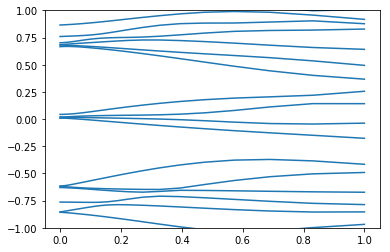

In [28]:
plt.plot(alphas, np.array(energies), 'C0');
plt.ylim(-1, 1)    

## explicit lowdin implementation

$
H^{(0)}_{ij} = (H_0)_{i,j}
$

$
H^{(1)}_{ij} = (H^\prime)_{i,j}
$

$
H^{(2)}_{ij} = \frac{1}{2} \sum_m \left[(H^\prime)_{i,m} (H^\prime)_{m, j} \times \left(\frac{1}{E_i-E_m} + \frac{1}{E_j - E_m} \right) \right]
$

In [29]:
%%time

def triproduct(left, matrix, right):
    return left.conjugate() @ matrix @ right

H_eff_1 = []
H_eff_2 = []

# iterate over states in group A
for i, j in itertools.product(indices, indices):
    
    # calculate 1-st order perturbation
    H_eff_1.append(triproduct(evec[:, i], H1, evec[:, j]))
    
    element = 0
    # iterate over states in group B
    for m in range(len(ev)):

        if m in indices:
            continue

        # This calculates H'_{im} H'_{mj} x (1 / (Ei - Em) + 1 / (Ej / Em))
        v1 = triproduct(evec[:, i], H1, evec[:, m])
        v2 = triproduct(evec[:, m], H1, evec[:, j])
        element += v1 * v2 * (1 / (ev[i] - ev[m]) + 1 / (ev[j] - ev[m]))
        
    H_eff_2.append(0.5 * element)
    
    
H_eff_0 = np.diag(ev[indices])    
H_eff_1 = np.array(H_eff_1).reshape(n, n)
H_eff_2 = np.array(H_eff_2).reshape(n, n)

CPU times: user 36.2 ms, sys: 1.92 ms, total: 38.1 ms
Wall time: 36.5 ms


In [30]:
H_eff_0

array([[ 0.00897664,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.0097627 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02055268,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.04303787]])

In [31]:
H_eff_1

array([[ 0.26281945+0.j        ,  0.07372099-0.10166788j,
        -0.11768556+0.0716986j ,  0.05095401+0.1060705j ],
       [ 0.07372099+0.10166788j, -0.02893966+0.j        ,
        -0.02720607+0.08011526j, -0.03012808+0.19884712j],
       [-0.11768556-0.0716986j , -0.02720607-0.08011526j,
        -0.04332026+0.j        ,  0.02291079-0.10600148j],
       [ 0.05095401-0.1060705j , -0.03012808-0.19884712j,
         0.02291079+0.10600148j,  0.03323084+0.j        ]])

In [32]:
H_eff_2

array([[-0.17178743+0.j        ,  0.05733175-0.06818855j,
        -0.06454276+0.25188911j, -0.18102196-0.03027433j],
       [ 0.05733175+0.06818855j, -0.04351514+0.j        ,
         0.01998499-0.00026977j, -0.05501013-0.18754685j],
       [-0.06454276-0.25188911j,  0.01998499+0.00026977j,
        -0.01370651+0.j        ,  0.01775352-0.04622804j],
       [-0.18102196+0.03027433j, -0.05501013+0.18754685j,
         0.01775352+0.04622804j, -0.00643592+0.j        ]])

In [33]:
# only h1_eff
energies_effective_1 = []
# up to h2_eff
energies_effective_2 = []

for alpha in alphas:
    H_eff = (H_eff_0 +
             alpha * H_eff_1 +
             0**2 * H_eff_2
            )
    
    e = la.eigvalsh(H_eff)
    energies_effective_1.append(e)
    H_eff = (H_eff_0 +
             alpha * H_eff_1 +
             alpha**2 * H_eff_2
            )
    
    e = la.eigvalsh(H_eff)
    energies_effective_2.append(e)

(-0.35, 0.35)

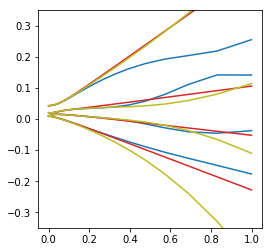

In [34]:
# first and second order

fig = plt.figure(figsize=(4,4))

plt.plot(alphas, np.array(energies), 'C0');
plt.plot(alphas, np.array(energies_effective_1), 'C3-');
plt.plot(alphas, np.array(energies_effective_2), 'C8-');
plt.ylim(-.35, .35)


In [35]:
import holoviews as hv
hv.notebook_extension()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Overlay
   .Path.I  :Path   [x,y]
   .Path.II :Path   [x,y]
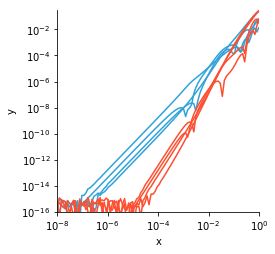

In [40]:
%%opts Overlay [logx=True logy=True]

(
    hv.Path((alphas, np.abs(energies[:,indices]-energies_effective_1))) *
    hv.Path((alphas, np.abs(energies[:,indices]-energies_effective_2)))
)[1e-8:,1e-16:]

# kpm improvement (below unfinished)

Goal is to optimize $H^{(2)}$ using KPM.

My rough understanding from the discussion comes here:

$
H^{(2)}_{ij} \rightarrow \frac{1}{2} <i | H^\prime  \left[\sum_m |m > < m| \left( \frac{1}{E_i-E_m} + \frac{1}{E_j - E_m}\right) \right] H^\prime |j>
$

Now with

$
\sum_m |m > < m| \frac{1}{E_i-E_m} = \sum_m |m > < m| \frac{1}{E_i-H_0} = P_B \frac{1}{E_i-E_m} = f(E_i, H_0)
$

we transform further into
$
H^{(2)}_{ij} \rightarrow \frac{1}{2} <i | H^\prime  \left[ f(E_i, H_0) + f(E_j, H_0) \right] H^\prime |j>
$

In [46]:
%%time

window = (-.25, +.25)
ev, evec = la.eigh(H0)

indices = [i for (i, e) in enumerate(ev) if window[0] < e < window[1]]
n = len(indices)

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 1.87 ms


In [47]:
%%time

def triproduct(left, matrix, right):
    return left.conjugate() @ matrix @ right

P_A = np.sum([np.outer(evec[:, i], evec[:, i]) for i in indices], 0)
P_B = np.ones_like(H0) - P_A

H_eff_1 = []
H_eff_2 = []

# iterate over states in group A
for i, j in itertools.product(indices, indices):
    
    # calculate 1-st order perturbation
    H_eff_1.append(triproduct(evec[:, i], H1, evec[:, j]))    
    
H_eff_0 = np.diag(ev[indices])    
H_eff_1 = np.array(H_eff_1).reshape(n, n)

CPU times: user 1.69 ms, sys: 0 ns, total: 1.69 ms
Wall time: 1.3 ms


In [48]:
from codes.kpm_funcs import build_perturbation

In [61]:
kpm_params = dict(num_moments=1000)
H_eff_2 = build_perturbation(ev[indices], evec[:,indices].T, H0, H1, kpm_params=kpm_params)

In [62]:
# only h1_eff
energies_effective_1 = []
# up to h2_eff
energies_effective_2 = []

for alpha in alphas:
    H_eff = (H_eff_0 +
             alpha * H_eff_1 +
             0**2 * H_eff_2
            )
    
    e = la.eigvalsh(H_eff)
    energies_effective_1.append(e)
    H_eff = (H_eff_0 +
             alpha * H_eff_1 +
             alpha**2 * H_eff_2
            )
    
    e = la.eigvalsh(H_eff)
    energies_effective_2.append(e)

(-0.35, 0.35)

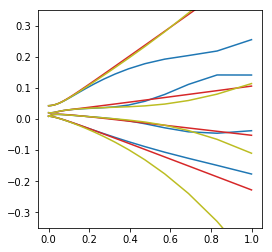

In [63]:
# first and second order

fig = plt.figure(figsize=(4,4))

plt.plot(alphas, np.array(energies), 'C0');
plt.plot(alphas, np.array(energies_effective_1), 'C3-');
plt.plot(alphas, np.array(energies_effective_2), 'C8-');
plt.ylim(-.35, .35)


:Overlay
   .Path.I  :Path   [x,y]
   .Path.II :Path   [x,y]
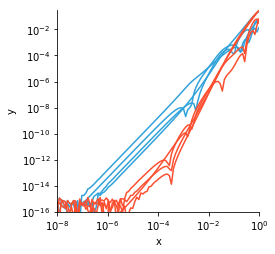

In [64]:
%%opts Overlay [logx=True logy=True]

(
    hv.Path((alphas, np.abs(energies[:,indices]-energies_effective_1))) *
    hv.Path((alphas, np.abs(energies[:,indices]-energies_effective_2)))
)[1e-8:,1e-16:]